# HW3
## Image Captioning with Conditioned LSTM Generators





Follow the instructions in this notebook step-by step. Much of the code is provided, but some sections are marked with **TODO**. 

Specifically, you will build the following components: 

* Create matrices of image representations using an off-the-shelf image encoder.
* Read and preprocess the image captions. 
* Write a generator function that returns one training instance (input/output sequence pair) at a time. 
* Train an LSTM language generator on the caption data.
* Write a decoder function for the language generator. 
* Add the image input to write an LSTM caption generator. 
* Beam search to refine output captions.

Each group please submit one copy of this notebook only, including all outputs. 

Reference:
https://medium.com/@raman.shinde15/image-captioning-with-flickr8k-dataset-bleu-4bcba0b52926#:~:text=Captions%20are%20read%20from%20Flickr8k.token.txt%20file%20and%20stored,format%20%E2%80%9Cstartseq%20%E2%80%9C%20%2B%20caption%20%2B%20%E2%80%9C%20endseq%E2%80%9D

### Getting Started 

First, run the following commands to make sure you have all required packages. 

In [29]:
# tested with python 3.6
import os
from collections import defaultdict
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation, Dropout
from keras.activations import softmax
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences

from keras.applications.inception_v3 import InceptionV3

from keras.optimizers import Adam

# from google.colab import drive

### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html

Dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k

You need to download the dataset and then upload it again to your own drive. Please assign the name you choose for this folder to the variable `my_data_dir` in the next cell.


In [30]:
#this is where you put the name of your data folder.
#Please make sure it's correct because it'll be used in many places later.
my_data_dir="hw3_data"

### Mounting your GDrive so you can access the files from Colab (optional)

In [31]:
#running this command will generate a message that will ask you to click on a link where you'll obtain your GDrive auth code.
#copy paste that code in the text box that will appear below
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Please look at the 'Files' tab on the left side and make sure you can see the 'hw5_data' folder that you have in your GDrive.

In [32]:
%cd /content/gdrive/MyDrive/HW3_DATA/hw3_data

/content/gdrive/MyDrive/HW3_DATA/hw3_data


## Part I: Understand the data (10 pts)

> Indented block



Read the caption file:

In [33]:
df = pd.read_csv(f'captions.txt')
print(df.shape)
df.head()

(40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Train, test split:

In [34]:
list_images = sorted([*set(df['image'].tolist())])
len(list_images)

8091

In [35]:
list_images[6472] #6472 is 80% of 8091

'3601569729_bf4bf82768.jpg'

In [36]:
# TODO: train, test split: 0.8: 0.2. ##splitting df using the image name to sorted captions into new df's  (training ,  testing) ,,, note :- captions are in sorted order 
train_df = df[df['image']<'3601569729_bf4bf82768']
test_df = df[df['image']>='3601569729_bf4bf82768']
train_df.shape,test_df.shape


((32360, 2), (8095, 2))

In [37]:
train_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [38]:
train_list= sorted([*set(list(train_df["image"].values))])
test_list= sorted([*set(list(test_df["image"].values))])

In [39]:
len(train_list),len(test_list)

(6472, 1619)

Each entry is an image filename.

Check an example:

In [40]:
example_file = train_df.iloc[9]['image']
cap = train_df.iloc[9]['caption']
image = Image.open(os.path.join('Images', example_file))
print(image.size)
print(cap)

(500, 375)
Two dogs on pavement moving toward each other .


If you can't see the image, try

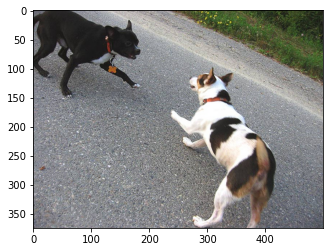

In [41]:
plt.imshow(image)

In [42]:
def load_image_list(filename):
  with open(filename,'r') as image_list_f:
    return [line.strip() for line in image_list_f]

## Part II: Image encoder (10 pts)
We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [43]:
np.asarray(image).shape

(375, 500, 3)

The values range from 0 to 255. 

In [44]:
np.asarray(image)

array([[[102, 103, 108],
        [ 95,  96, 101],
        [ 99, 100, 105],
        ...,
        [ 29,  29,  21],
        [ 31,  28,  23],
        [ 30,  25,  22]],

       [[108, 109, 114],
        [100, 101, 106],
        [ 94,  95, 100],
        ...,
        [ 37,  37,  29],
        [ 37,  34,  29],
        [ 33,  28,  25]],

       [[112, 112, 120],
        [118, 118, 126],
        [100, 100, 108],
        ...,
        [ 40,  40,  32],
        [ 37,  34,  29],
        [ 34,  31,  26]],

       ...,

       [[103, 101, 114],
        [104,  98, 110],
        [122, 114, 127],
        ...,
        [ 83,  88,  94],
        [ 76,  83,  89],
        [ 72,  79,  85]],

       [[111, 114, 121],
        [ 91,  88,  97],
        [ 85,  78,  86],
        ...,
        [ 95, 100, 106],
        [ 79,  84,  90],
        [ 79,  84,  90]],

       [[ 93,  96, 101],
        [ 69,  66,  73],
        [111, 101, 109],
        ...,
        [ 88,  91,  98],
        [ 82,  85,  92],
        [ 94,  99, 105]]

We can use PIL to resize the image and then divide every value by 255. 

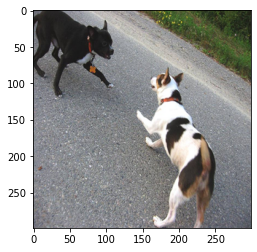

In [45]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [46]:
new_image.shape

(299, 299, 3)

Let's put this all in a function for convenience. 

In [47]:
def read_image(image_name):
    image = Image.open(os.path.join('Images', image_name))
    return np.asarray(image.resize((299,299))) / 255.0                     

Next, we load the pre-trained Inception model. 

In [48]:
img_model = InceptionV3(weights='imagenet') # This will download the weight files for you and might take a while.

In [49]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We will use the following hack: hook up the input into a new Keras model and use the penultimate layer of the existing model as output.

In [50]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model we will use.

Let's try the encoder. 

In [51]:
encoded_image = img_encoder.predict(np.array([new_image]))

1/1 [==============================] - 1s 1s/step


In [52]:
encoded_image.shape

(1, 2048)

**TODO:** We will need to create encodings for all images and store them in one big matrix (one for each dataset, train, test).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) we will read in the images lazily using a generator. We will encounter generators again later when we train the LSTM. If you are unfamiliar with generators, take a look at this page: https://wiki.python.org/moin/Generators

Write the following generator function, which should return one image at a time. 
`img_list` is a list of image file names (i.e. the train, dev, or test set). The return value should be a numpy array of shape (1,299,299,3).

Now we can encode all images (this takes a few minutes).

In [53]:
def img_generator(img_list):
  for i in img_list:
    Len_img_list = len(img_list)
    K = i[Len_img_list:]
    if K in 'Images':
      img = read_image(i)
      img_id = np.expand_dims(img, axis=0) #adding one more dimension as we need array of shape (1,299,299,3)
      yield img_id # shape: (1, 299, 299, 3)
 


In [54]:
enc_train = img_encoder.predict(img_generator(train_list), steps=len(train_list), verbose=1)

6472/6472 [==============================] - 94s 14ms/step


In [55]:
enc_train.shape

(6472, 2048)

In [56]:
enc_test = img_encoder.predict(img_generator(test_list), steps=len(test_list), verbose=1)

1619/1619 [==============================] - 24s 15ms/step


It's a good idea to save the resulting matrices, so we do not have to run the encoder again. 

In [57]:
np.save(f"encoded_images_train.npy", enc_train)
np.save(f"encoded_images_test.npy", enc_test)

## Part III Text (Caption) Data Preparation (10 pts)

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

**TODO**: Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file. Data from https://github.com/text-machine-lab/MUTT/tree/master/data/flickr

The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a START token on the left and an END token on the right. 

In [58]:
from collections import defaultdict

def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)
    # TODO: here
    caption_list = []
    for line in open(filename,'r'):
      caption_list.append(line.strip())
    
      #splitting captions
    for i in caption_list[:-1]:
      img, i = i.split('\t')
      i = i.lower().split()                      #making it lowercase
      desc = '<START> ' + ' '.join(i) + ' <END>' #adding <START> and <END> for every sublist 
      desc = desc.split()
      if img[:-2] in image_descriptions:
        image_descriptions[img[:-2]].append(desc)
      else:
        image_descriptions[img[:-2]] = [desc]
    return image_descriptions


In [59]:
# Populating description dictionary using the above method
descriptions = read_image_descriptions(f"Flickr8k.token.txt")

In [60]:
len(descriptions)

8092

In [61]:
print(descriptions[train_list[0]])

[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<END>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<END>']]


Running the previous cell should print similar to this:     
`[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<END>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<END>']]
`    

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. **TODO** create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  
Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries. 

In [62]:
# TODO: 
# Creating the unique words list, using the set and list sort method
train_descriptions = {} 
for i in train_list:
  for k, val in descriptions.items():
    if i == k:
      train_descriptions[k] = val


In [63]:
#train_list[0:5]

In [64]:
#dict(list(train_descriptions.items())[:2])

In [65]:
# TODO:
import collections
word_tkn = []
for i in train_descriptions.values():
  for each_caption in i:
    for tkn in each_caption:
        word_tkn.append(tkn)
        
word_tkn = [*set(word_tkn)]

word_tkn = sorted(word_tkn)

id_to_word = {}
word_to_id = {}
# id_to_word = #..
for i, j in enumerate(word_tkn):
  id_to_word[i+1] = j
# word_to_id = #...
  word_to_id[j] = i+1

In [66]:
word_to_id['dog'] # should print an integer

2108

In [67]:
id_to_word[1985] # should print a token

'designs'

In [68]:
len(word_to_id)

8112

In [69]:
len(id_to_word)

8112

Note that we do not need an UNK word token because we are generating. The generated text will only contain tokens seen at training time.  

## Part IV Basic Decoder Model (20 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input. 

There are different ways to do this and our approach will be slightly different from the generator discussed in class. 

The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [70]:
max(len(description) for image_id in train_list for description in descriptions[image_id])
vocab_size = len(word_to_id)

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

Instead, we will use the model to predict one word at a time, given a partial sequence. For example, given the sequence ["START","a"], the model might predict "dog" as the most likely word. We are basically using the LSTM to encode the input sequence up to this point. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm2.png" width="480px">


To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train the model using the following input/output pairs 

| i | input                        | output |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `END`  |



Here is the model in Keras Keras. Note that we are using a Bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 
Also note the `return_sequence=False` parameter, which causes the LSTM to return a single output instead of one output per state. 

$$p(x) = \Pi_1^{n}p(x_i | x_1, ..., x_{i-1}, img)$$

Note also that we use an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [71]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 300)           2433600   
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             3330048   
 l)                                                              
                                                                 
 dense (Dense)               (None, 8112)              8314800   
                                                                 
Total params: 14,078,448
Trainable params: 14,078,448
Non-trainable params: 0
_________________________________________________________________


The model input is a numpy ndarray (a tensor) of size `(batch_size, MAX_LEN)`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with 0. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a numpy ndarray of size `(batch_size, vocab_size)`. vocab_size is the number of vocabulary words. 

### Creating a Generator for the Training Data

**TODO**: 

We could simply create one large numpy ndarray for all the training data. Because we have a lot of training instances (each training sentence will produce up to MAX_LEN input/output pairs, one for each word), it is better to produce the training examples *lazily*, i.e. in batches using a generator (recall the image generator in part I). 

Write the function `text_training_generator` below, that takes as a paramater the batch_size and returns an `(input, output)` pair. `input` is a `(batch_size, MAX_LEN)` ndarray of partial input sequences, `output` contains the next words predicted for each partial input sequence, encoded as a `(batch_size, vocab_size)` ndarray.

Each time the next() function is called on the generator instance, it should return a new batch of the *training* data. You can use `train_list` as a list of training images. A batch may contain input/output examples extracted from different descriptions or even from different images. 

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc. 


Hint: To prevent issues with having to reset the generator for each epoch and to make sure the generator can always return exactly `batch_size` input/output pairs in each step, wrap your code into a `while True:` loop. This way, when you reach the end of the training data, you will just continue adding training data from the beginning into the batch. 

In [72]:
# TODO: data generator, intended to be used in a call to model.fit_generator()
def text_training_generator(batch_size=128):
  text_input = []
  output_list = []
  c = 0
  
  while True:
    for p in train_list:
      for x in descriptions[p]:
        for i in range(len(x)):
          c += 1
        
          if c < batch_size:
            v = np.zeros(40, dtype = int)  #setting up Input array shape

            for j in range(i):
              v[j] = word_to_id[x[j]]

            if i == 0:
              continue
              
            text_input.append(v)
            result = np.zeros(vocab_size, dtype = int)     #setting up output array shape
            result[word_to_id[x[j+1]]] = 1
            output_list.append(result)
 
          else:
              yield (np.array(text_input), np.array(output_list))

      

### Training the Model

We will use the `fit_generator` method of the model to train the model. fit_generator needs to know how many iterator steps there are per epoch.

Because there are len(train_list) training samples with up to `MAX_LEN` words, an upper bound for the number of total training instances is `len(train_list)*MAX_LEN`. Because the generator returns these in batches, the number of steps is len(train_list) * MAX_LEN // batch_size

In [73]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [74]:
model.fit(generator, steps_per_epoch=steps, verbose=True, epochs=10)

Epoch 1/10
2022/2022 [==============================] - 32s 14ms/step - loss: 0.4051 - accuracy: 0.8531
Epoch 2/10
2022/2022 [==============================] - 27s 14ms/step - loss: 0.1681 - accuracy: 0.9153
Epoch 3/10
2022/2022 [==============================] - 28s 14ms/step - loss: 0.1680 - accuracy: 0.9153
Epoch 4/10
2022/2022 [==============================] - 28s 14ms/step - loss: 0.1679 - accuracy: 0.9153
Epoch 5/10
2022/2022 [==============================] - 27s 13ms/step - loss: 0.1679 - accuracy: 0.9153
Epoch 6/10
2022/2022 [==============================] - 27s 13ms/step - loss: 0.1679 - accuracy: 0.9153
Epoch 7/10
2022/2022 [==============================] - 27s 14ms/step - loss: 0.1678 - accuracy: 0.9153
Epoch 8/10
2022/2022 [==============================] - 28s 14ms/step - loss: 0.1678 - accuracy: 0.9153
Epoch 9/10
2022/2022 [==============================] - 28s 14ms/step - loss: 0.1678 - accuracy: 0.9153
Epoch 10/10
2022/2022 [==============================] - 28s 14m

Continue to train the model until you reach an accuracy of at least 40%. 

### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [75]:
def decoder():
  output_list = ["<START>"]
      # TODO:
  for i in range(MAX_LEN - 1):
    input = np.zeros(40, dtype = int) #setting up Input array shape


    for i in range(len(output_list)):
      input[i] = word_to_id[output_list[i]]  

    input = input.reshape(1, MAX_LEN)
    mp = model.predict([input],verbose =0)  #predicting using model
    pred = np.argmax(mp)
    output_list.append(id_to_word[pred])

    if id_to_word[pred] == "<END>":
      return " ".join(output_list)


In [76]:
print(decoder())

<START> a black dog and a tri-colored dog playing with each other on the road . <END>


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Take a look at the [np.random.multinomial](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html) function to do this. 

In [77]:
def sample_decoder():
  output_list = ["<START>"]
      # TODO:
  for i in range(MAX_LEN - 1):
    input = np.zeros(40, dtype = np.float32)  #setting up Input array shape

    for i in range(len(output_list)):
      input[i] = word_to_id[output_list[i]]

    input = input.reshape(1, MAX_LEN)
    pred = model.predict([input],verbose =0)
    pred = np.asarray(pred).astype('float64')    #predicting using model
    pred = pred.astype(float)
    pred[0] /= pred[0].sum()
    res = np.random.multinomial(1,pred[0]) #random the next from the distribution 
    res = list(res).index(1)

    output_list.append(id_to_word[res])

    if id_to_word[res] == "<END>":
      return " ".join(output_list)

You should now be able to see some interesting output that looks a lot like flickr8k image captions -- only that the captions are generated randomly without any image input. 

In [78]:
for i in range(10):
  print(sample_decoder())

<START> a little girl climbing into a wooden playhouse . <END>
<START> a little girl in a pink dress going into a wooden cabin . <END>
<START> two dogs of different breeds looking at each other on the road . <END>
<START> a black dog and a spotted dog are fighting <END>
<START> two dogs of different breeds looking at each other on the road . <END>
<START> a black dog and a spotted dog are fighting <END>
<START> a child in a pink dress is climbing up a set of stairs in an entry way . <END>
<START> two dogs of different breeds looking at each other on the road . <END>
<START> a little girl climbing into a wooden playhouse . <END>
<START> a black dog and a tri-colored dog playing with each other on the road . <END>


## Part V - Conditioning on the Image (20 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the Keras model looks like: 

In [79]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()




Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 300)          614700      ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 40, 300)      0           ['dense_1[0][0]']                
                                                                                            

The model now takes two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

**TODO**: Modify the training data generator to include the image with each input/output pair. 
Your generator needs to return an object of the following format: `([image_inputs, text_inputs], next_words)`. Where each element is an ndarray of the type described above.  

You need to find the image encoding that belongs to each image. You can use the fact that the index of the image in `train_list` is the same as the index in enc_train and enc_dev. 

If you have previously saved the image encodings, you can load them from disk: 

In [80]:
enc_train = np.load("encoded_images_train.npy")
enc_test = np.load("encoded_images_test.npy")


In [81]:
def training_generator(batch_size=2048):
  img_input=[]
  c = 0
  text_input = []
  output_txt = []

  while True:
    for p in train_list:
      for x in descriptions[p]:
        for i in range(len(x)):
          c += 1
        
          if c < batch_size:
            v = np.zeros(40, dtype = int)  #setting up Input array shape

            for j in range(i):
              v[j] = word_to_id[x[j]]

            if i == 0:
              continue

            img_input.append(enc_train[train_list.index(p)])
            text_input.append(v)
            result = np.zeros(vocab_size, dtype = int)  #predicting using model
            result[word_to_id[x[j+1]]] = 1
            output_txt.append(result)

          else:
              yield ([np.array(img_input),np.array(text_input)], np.array(output_txt))

You should now be able to train the model as before: 

In [82]:
batch_size = 2048
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [83]:
model.fit(generator, steps_per_epoch=steps, verbose=1, epochs=10)

Epoch 1/10
126/126 [==============================] - 12s 68ms/step - loss: 3.9639 - accuracy: 0.1267
Epoch 2/10
126/126 [==============================] - 8s 67ms/step - loss: 2.3763 - accuracy: 0.2773
Epoch 3/10
126/126 [==============================] - 9s 68ms/step - loss: 1.5756 - accuracy: 0.4690
Epoch 4/10
126/126 [==============================] - 9s 68ms/step - loss: 0.9879 - accuracy: 0.6813
Epoch 5/10
126/126 [==============================] - 9s 68ms/step - loss: 0.5360 - accuracy: 0.8472
Epoch 6/10
126/126 [==============================] - 9s 68ms/step - loss: 0.2844 - accuracy: 0.9104
Epoch 7/10
126/126 [==============================] - 9s 68ms/step - loss: 0.2079 - accuracy: 0.9204
Epoch 8/10
126/126 [==============================] - 9s 68ms/step - loss: 0.1570 - accuracy: 0.9315
Epoch 9/10
126/126 [==============================] - 9s 68ms/step - loss: 0.1550 - accuracy: 0.9307
Epoch 10/10
126/126 [==============================] - 8s 67ms/step - loss: 0.1392 - accur

Again, continue to train the model until you hit an accuracy of about 40%. This may take a while. I strongly encourage you to experiment with cloud GPUs using the GCP voucher for the class. 

You can save your model weights to disk and continue at a later time. 

In [84]:
model.save_weights("model.h5")

to load the model: 

In [85]:
model.load_weights("model.h5")

dcaptions = df_txt0["caption"].iloc[keepindex].values**TODO**: Now we are ready to actually generate image captions using the trained model. Modify the simple greedy decoder you wrote for the text-only generator, so that it takes an encoded image (a vector of length 2048) as input, and returns a sequence.

In [86]:
def image_decoder(enc_image):
  output_list = ['<START>']
    # TODO:
  len = MAX_LEN-1
  txt = output_list[0]
  c = 0
  for i in range(MAX_LEN - 1):
    input_txt = np.zeros((1,40), dtype = int)    #setting up Input array shape

    while c < len and txt != "<END>":
      input_txt[0][c] = word_to_id[txt]
      pred = model.predict([enc_image, input_txt],verbose =0)     #predicting model
      word = id_to_word[np.argmax(pred)]
      c += 1 
      if word != txt:
        input_txt[0][c] = word_to_id[word]
        output_list.append(word)
        txt = word
      
    return " ".join(output_list)   

<START> a little girl climbing the stairs to her playhouse . <END>


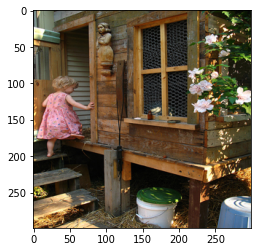

In [87]:
idx = 0
image = np.array(enc_train[idx]).reshape(1,2048)
t = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print(image_decoder(image))

<START> a black dog and a tri-colored dog playing with each other on the road . <END>


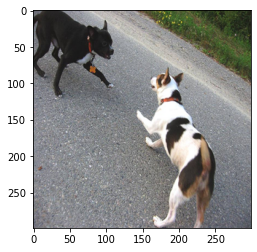

In [88]:
# Training image test-1
idx = 1
image = np.array(enc_train[idx]).reshape(1,2048)
t = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print(image_decoder(image))

<START> a dog is running in the snow <END>


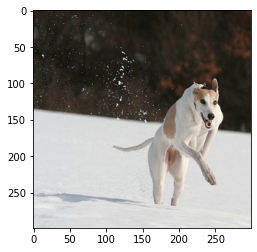

In [89]:
idx = 10
image = np.array(enc_train[idx]).reshape(1,2048)
t = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print(image_decoder(image))

<START> a white dog is about to catch a yellow dog toy . <END>


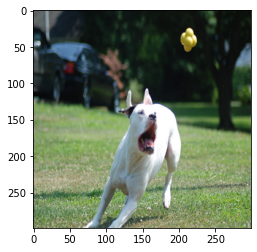

In [90]:
idx = 14
image = np.array(enc_train[idx]).reshape(1,2048)
t = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print(image_decoder(image))

You should also be able to apply the model to dev images and get reasonable captions:

'<START> a man and man and girl in a front the of a he walks in front . <END>'

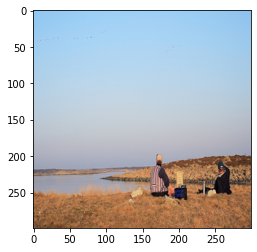

In [91]:
# Testing test image 1
idx = 817
t = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
image_decoder(t)

## Part VII Beam search (10 pts)

**TODO**: Use beam search algorithm to refine the output captions.

Reference: https://keras.io/api/keras_nlp/utils/beam_search/

https://keras.io/examples/nlp/text_generation_gpt/

In [92]:
def beam_search(image, beam_index = 5, log = False):
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    output_list = [[[word_to_id["<START>"]], 0.0]]
    
    while len(output_list[0][0]) < MAX_LEN:
        temp = []
        for s in output_list:
            par_caps = pad_sequences([s[0]], maxlen=MAX_LEN, padding='post').reshape((1,MAX_LEN))
            e = image
            preds = model.predict([e,par_caps],verbose = 0)
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:           #log functions - to predict
                    prob += np.log(preds[0][w]) 
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        output_list = temp
        output_list = sorted(output_list, reverse=False, key=lambda l: l[1])
        output_list = output_list[-beam_index:]
    
    output_list = output_list[-1][0]
    intermediate_caption = [id_to_word[i] for i in output_list]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<END>':
            final_caption.append(i)
        else:
            final_caption.append(i)
            break
    
    final_caption = ' '.join(final_caption)
    return final_caption

**TODO**: Randomly plot 10 images with captions from train set and test set each.

### Training Results

Prediction 1
Greedy Search generated Captions

<START> a little girl climbing the stairs to her playhouse . <END> 

Beam Search generated Captions

<START> a little girl climbing the stairs to her playhouse . <END>
<START> a girl going into a wooden building . <END>
<START> a little girl in a pink dress going into a wooden cabin . <END>
<START> a child in a pink dress is climbing up a set of stairs in an entry way . <END>


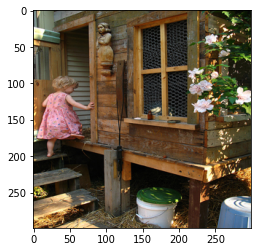

In [93]:
idx = 0

print("Prediction 1")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=False))
print(beam_search(image, beam_index = 3, log=True))
print(beam_search(image, beam_index = 4, log=True))


Prediction 2
Greedy Search generated Captions

<START> a group of people climbing a rock while one man belays <END> 

Beam Search generated Captions

<START> a group of people climbing a rock while one man belays <END>
<START> seven climbers are ascending a rock face whilst another man stands holding the rope . <END>
<START> several climbers in a row are climbing the rock while the man in red watches and holds the line . <END>
<START> a group of people are rock climbing on a rock climbing wall . <END>


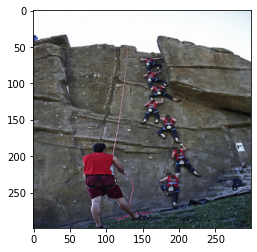

In [94]:
idx = 12

print("Prediction 2")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=False))
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 3, log=True))


Prediction 3
Greedy Search generated Captions

<START> a grey dog is leaping over a fallen tree . <END> 

Beam Search generated Captions

<START> a grey dog is leaping over a fallen tree . <END>
<START> a mottled black and grey dog in a blue collar jumping over a fallen tree . <END>
<START> a mottled black and grey dog in a blue collar jumping over a fallen tree . <END>
<START> a large black dog leaps a fallen log . <END>


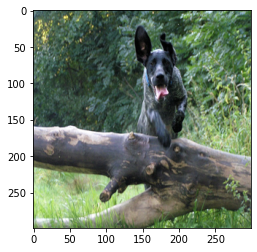

In [95]:
idx = 9

print("Prediction 3")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 3, log=True))
print(beam_search(image, beam_index = 8, log=False))


Prediction 4
Greedy Search generated Captions

<START> a couple and an infant , being held by the male , sitting next to a pond with a near by stroller . <END> 

Beam Search generated Captions

<START> a couple and an infant , being held by the male , sitting next to a pond with a near by stroller . <END>
<START> a man and woman care for an infant along the side of a body of water . <END>
<START> a man and woman care for an infant along the side of a body of water . <END>
<START> a man and woman care for an infant along the side of a body of water . <END>


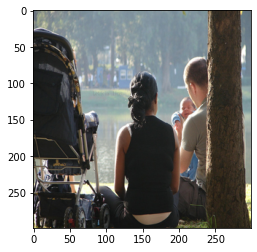

In [96]:
idx = 17

print("Prediction 4")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 5
Greedy Search generated Captions

<START> a black dog and a tri-colored dog playing with each other on the road . <END> 

Beam Search generated Captions

<START> a black dog and a white dog with brown spots are staring at each other in the street . <END>
<START> a black dog and a tri-colored dog playing with each other on the road . <END>
<START> a black dog and a white dog with brown spots are staring at each other in the street . <END>
<START> a black dog and a white dog with brown spots are staring at each other in the street . <END>


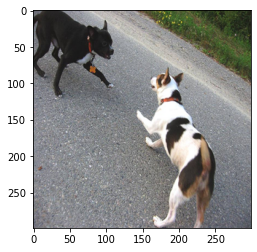

In [97]:

idx = 1

print("Prediction 5")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 3, log=True))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 8, log=False))
print(beam_search(image, beam_index = 3, log=True))


Prediction 6
Greedy Search generated Captions

<START> a little girl is sitting in front of a large painted rainbow . <END> 

Beam Search generated Captions

<START> a little girl is sitting in front of a large painted rainbow . <END>
<START> a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . <END>
<START> a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . <END>
<START> a little girl is sitting in front of a large painted rainbow . <END>


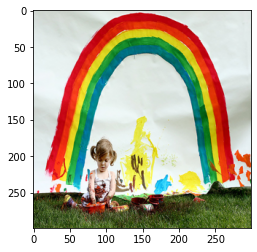

In [123]:
idx = 2
print("Prediction 6")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 8, log=False))
print(beam_search(image, beam_index = 3, log=True))
print(beam_search(image, beam_index = 1, log=True))



Prediction 7
Greedy Search generated Captions

<START> a man with glasses is wearing a beer can crocheted hat . <END> 

Beam Search generated Captions

<START> the man with pierced ears is wearing glasses and an orange hat . <END>
<START> a man with gauges and glasses is wearing a blitz hat . <END>
<START> a man with gauges and glasses is wearing a blitz hat . <END>
<START> a man with glasses is wearing a beer can crocheted hat . <END>


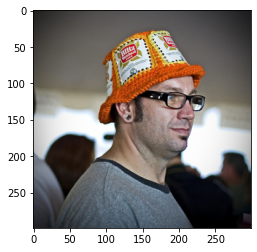

In [99]:
idx = 4
print("Prediction 7")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 8, log=False))
print(beam_search(image, beam_index = 3, log=True))
print(beam_search(image, beam_index = 2, log=True))


Prediction 8
Greedy Search generated Captions

<START> a dog shakes its head near the shore , a red ball next to it . <END> 

Beam Search generated Captions

<START> a dog shakes its head near the shore , a red ball next to it . <END>
<START> a dog shakes its head near the shore , a red ball next to it . <END>
<START> dog with orange ball at feet , stands on shore shaking off water <END>
<START> dog with orange ball at feet , stands on shore shaking off water <END>


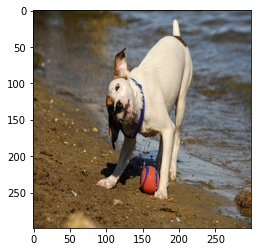

In [122]:
idx = 7
print("Prediction 8")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=False))
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 4, log=False))


Prediction 9
Greedy Search generated Captions

<START> a boston terrier is running in the grass . <END> 

Beam Search generated Captions

<START> a boston terrier is running in the grass . <END>
<START> a black and white dog is running in a grassy garden surrounded by a white fence . <END>
<START> a black and white dog is running in a grassy garden surrounded by a white fence . <END>
<START> a black and white dog is running in a grassy garden surrounded by a white fence . <END>


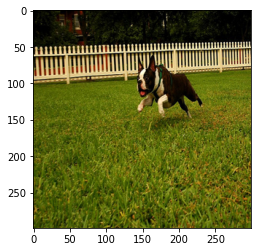

In [101]:
idx = 6
print("Prediction 9")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=False))
print(beam_search(image, beam_index = 5, log=False))
print(beam_search(image, beam_index = 4, log=True))


Prediction 10
Greedy Search generated Captions

<START> a young child is walking on a stone paved street with a metal pole and a man behind him . <END> 

Beam Search generated Captions

<START> a young child is walking on a stone paved street with a metal pole and a man behind him . <END>
<START> a little boy is standing on the street while a man in overalls is working on a stone wall . <END>
<START> a little boy is standing on the street while a man in overalls is working on a stone wall . <END>
<START> a young child is walking on a stone paved street with a metal pole and a man behind him . <END>


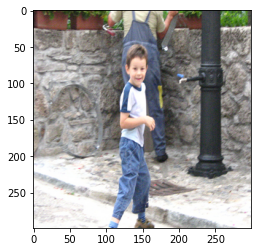

In [118]:
idx = 8
print("Prediction 10")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 8, log=False))
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 4, log=True))



### TESTING Results


Prediction 2
Greedy Search generated Captions

<START> a man and man and sitting in a front the of a he walks in a in a glass . <END> 

Beam Search generated Captions

<START> a man and man and sitting in a front the of a he walks in a in a glass . <END>
<START> a man and man and sitting in a front the of a he walks in a in water . <END>
<START> a man and man and sitting in a front the of a he walks in a in a glass . <END>
<START> a man in a playing in the grass . <END>


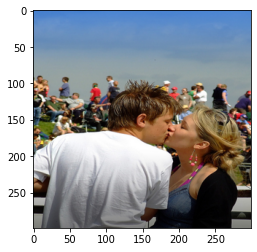

In [104]:

idx = 1
print("Prediction 1")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 3
Greedy Search generated Captions

<START> a man in a is sitting in a front a in a in a in a in a bowl . <END> 

Beam Search generated Captions

<START> a man in a is sitting in a front a a in a in a in a in a bowl . <END>
<START> a man in a is sitting in a front a a in a in a in water . <END>
<START> a man in a is sitting in a front a a in a in a in a in a bowl . <END>
<START> a man in in the grass with a <END>


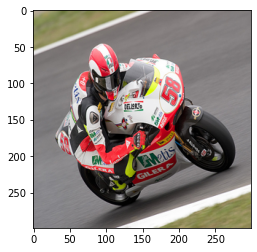

In [105]:
idx = 2
print("Prediction 2")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 4
Greedy Search generated Captions

<START> a man in a sitting in a front of a of a in art reading . <END> 

Beam Search generated Captions

<START> a man in in a a sitting in a front of a of a in art reading . <END>
<START> a man in in a a sitting in a front of a of a in water . <END>
<START> a man in in a a sitting in a front of a of a in art reading . <END>
<START> a man in in a a sitting in a front of a of a in water . <END>


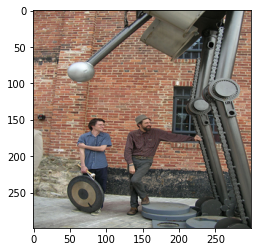

In [106]:
idx = 3
print("Prediction 3")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 5
Greedy Search generated Captions

<START> a man in a is sitting in front a building . <END> 

Beam Search generated Captions

<START> a man in a is sitting in front a a building . <END>
<START> a man in a is sitting in front a a building . <END>
<START> a man in a is sitting in front a a building . <END>
<START> a man in a wearing a sitting in front a her . <END>


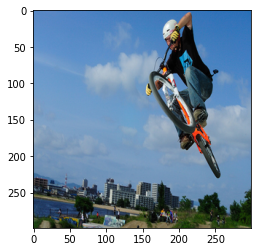

In [107]:
idx = 4
print("Prediction 4")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 6
Greedy Search generated Captions

<START> a man in leaps the grass <END> 

Beam Search generated Captions

<START> a man in leaps the the grass <END>
<START> a man in leaps the the grass <END>
<START> a man in leaps the the grass <END>
<START> a black dog in the the log . <END>


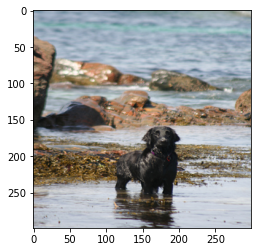

In [108]:
idx = 5
print("Prediction 5")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 8
Greedy Search generated Captions

<START> a man and man and sitting in a front the of a he walks in a in water . <END> 

Beam Search generated Captions

<START> a man and man and sitting in a front the of a he walks in a in water . <END>
<START> a man and man and sitting in a front the of a he walks in in water . <END>
<START> a man and man and sitting in a front the of a he walks in a in water . <END>
<START> a man in the with a red in a lake . <END>


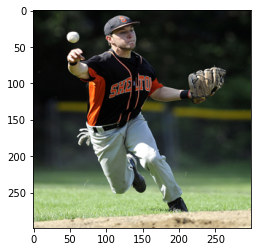

In [110]:
idx = 7
print("Prediction 7")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 9
Greedy Search generated Captions

<START> a man in a playing in a <END> 

Beam Search generated Captions

<START> a man in a playing in a a <END>
<START> a man in in a a red in a lake . <END>
<START> a man in a playing in a a <END>
<START> a man man shakes in the grass . <END>


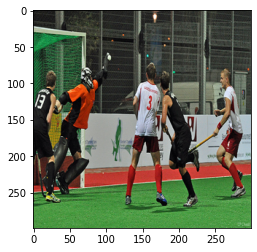

In [111]:
idx = 8
print("Prediction 8")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 10
Greedy Search generated Captions

<START> a man in splashes the with a <END> 

Beam Search generated Captions

<START> a man in splashes the with a <END>
<START> a man in splashes the grass . <END>
<START> a man in splashes the with a <END>
<START> a man in splashes the grass . <END>


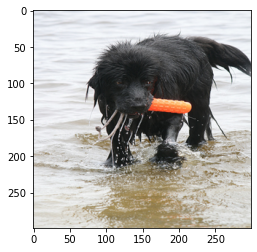

In [112]:
idx = 9
print("Prediction 9")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 1
Greedy Search generated Captions

<START> a man and man and girl in a front the of a he walks in front . <END> 

Beam Search generated Captions

<START> a man and man and girl in a front the of a he walks walks in front . <END>
<START> a man and man and girl in a front the of a he walks walks in front . <END>
<START> a man and man and girl in a front the of a he walks walks in front . <END>
<START> a man in on a red in a lake . <END>


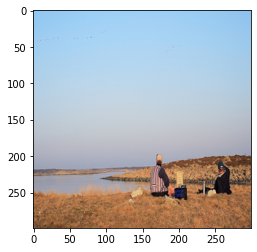

In [124]:
idx = 817
print("Prediction 10")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Greedy Search generated Captions\n")
print(image_decoder(image),"\n")
print("Beam Search generated Captions\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))